# Description
This code implements 1D Dilated convolutional DenseNet for machine learning on time-series with domain adversarial regularization.The dilated convolutions were used inspired by the WaveNet architecture [2]. The implementation follows the findings of the original paper on DenseNets [1] with some small differences.

* Each convolution block is a composite operation with "1x1" 1D convolution (A better term would be "filter-wise multiplication), BatchNorm, 1D Convolution with kernel size $k$
* Dilated convolutions are used (dilation $d$) in order to have a larger receptive field and facilitate the learning of multi-scale features
* Instead of explicitly concatenating the layers they are kept in a list. The original implementation was in pytorch and some memory efficiency condiderations ([1] section 3.2.1)- it seems TensorFlow is smart enough not to make redundant copies in-memory for the operations.
* Adversarial domain generalization is achieved with the gradient reversal technique described in [2]


## References
[[1]](https://ieeexplore.ieee.org/document/8721151) Convolutional Networks with Dense Connectivity

[[2]](https://arxiv.org/abs/1609.03499) A Generative Model for Raw Audio

[[3]](https://arxiv.org/abs/1505.07818) Domain-Adversarial Training of Neural Networks
## Usage
Three separate json files are used for managing 
* the pre-processing of the data
* the network parametrization
* the training 

Model checkpoints and training/validation losses are saved to disk for subsequent manual inspection for model selection.

### Network structure definition
The network structure is parametrized by a single json file, that contains the input shape, different layer stacks and at least two outputs. One of the inputs should have the property `"id":"timeseries_input"`. This defines the input layer of the time-series. Although the network can produce results for time-series of arbitrary lengths, the length of the time-series during training is required. The input with `"id":"domain_input"` is used for the domain adversarial loss from the $G_d$ classifier and it is also required.




# UNDER CONSTRUCTION! 
* dataset not publicly available
* will be updated with a publicly available dataset


In [1]:
import tensorflow as tf
#tf.enable_eager_execution()
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as pplot
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, AveragePooling1D, GlobalAveragePooling1D, Flatten, BatchNormalization, Dropout

import os

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = InteractiveSession(config=config)
tf.keras.backend.set_session(sess)
from tensorflow.math import confusion_matrix


In [55]:
from src.dilated_densenet_adversarial import make_model, make_densenet_parametrization_dictionary

In [56]:
%load_ext autoreload
%autoreload 
#%debug
#from src.dilated_densenet_adversarial import make_model
#from src.dilated_densenet_adversarial import make_densenet_parametrization_dictionary
from src.util import plot_confusion_matrix
from src.experiments_utils import *
#from src.dilated_densenet_adversarial import *

ndn = 4
ndn2 = 4

experiment_parametrization = {
    'dilation_rates_dn1': [4,8,16,32,4],
    'kernel_sizes_dn1' : [5,5,5,5,5,5],
    'nfilters_dn1' :  [20]*ndn,
    'dilation_rates_dn2' : [4]*ndn2,
    'kernel_sizes_dn2' : [5]*ndn2,
    'nfilters_dn2': [10]*ndn2
}

make_network_description_experiments_A(**experiment_parametrization)
model_json = make_network_json_experiments_A(**experiment_parametrization)
#model_json['domain_classifier']['network_layers'][0]['params']['units'] = 500
#model_json['classifier']['network_layers'][0]['params']['units'] = 500


# pred_c = {
#     'network_layers': [
#         {
#             'type': 'Dense',
#             'id': 'prediction',
#             'params': {'units': 10, 'name': 'Y_output'}
#         }
#     ]
# }
# pred_d = {
#     'network_layers': [
#         {
#             'type': 'Dense',
#             'id': 'prediction',
#             'params': {'units': 3, 'name': 'ExpID'}
#         }
#     ]
#}
# model_json['classifier'] = pred_c
# model_json['domain_classifier'] = pred_d
#
model_json["classifier"]["network_layers"][-1]['params']['units'] = 10
model_json["densenet_1d"]["network_layers"][0]["params"]["Variational"] = False
model_json["densenet_1d"]["network_layers"] = [
    model_json["densenet_1d"]["network_layers"][0],model_json["densenet_1d"]["network_layers"][-1]
]
#model_json['domain_classifier']['network_layers'][0]['type'] = 'DenseLocalReparameterization'
#del model_json['domain_classifier']['network_layers'][0]['params']["use_bias"]
#model_json['classifier']['network_layers'][0]['type'] = 'DenseLocalReparameterization'
#del model_json['classifier']['network_layers'][0]['params']['use_bias']

model = make_model(model_json)

#model.summary()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Tensor("DN_DN1_ConcatOut_5/concat:0", shape=(?, 1500, 160), dtype=float32)


In [45]:
inspect_model = keras.Model(inputs = model.layers[0].input,outputs = model.get_layer("DN_DN1_Out").output)
#inspect_model2 = keras.Model(inputs = model.layers[0].input,outputs = model.get_layer("DN_DN2_Out").output)
from tensorflow_probability import distributions as tfd


In [6]:
#p = inspect_model.predict(Xtrain[::123,:,:],batch_size = 100)


In [7]:
def plot_dn_output_activation_statistics():
    p1 = inspect_model.predict(Xtrain[::123,:,:], batch_size=50)
    p2 = inspect_model.predict(Xtest[::123,:,:], batch_size=50)
    #pout_test = inspect_model2.predict(Xtest[::123,:,:], batch_size=50)
    pplot.figure(figsize = (20,10))
    
    def plt_stuff(iistart, stuff):
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.mean(stuff,1))
        pplot.title('mean - train - sl1')
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.std(stuff,1))
        pplot.title('std - train - sl1')
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.mean(stuff,0))
        pplot.title("mean - test - sl0")    
        iistart+=1; pplot.subplot(2,4,iistart)
        pplot.pcolor(np.std(stuff,0))
        pplot.title("std - test - sl0")
    plt_stuff(0,p1)
    plt_stuff(4,p2)
    
# plot_dn_output_activation_statistics()

# Data preparation 
Normally there are two more time-consuming pre-processing steps.Namely,
 * The data are first sub-sampled (to 200 cycles every 20000 cycles) and then
 * each cycle is re-sampled to have the same number of points, namely 300 points per cycle.  

In this post-processing stage, a certain ammount of cycles from the end is considered (150k ~ 300k) because any prediction for cycles earlier than that should not work for physical reasons (and since we are having limited experiments). In this final stage of pre-processing unique re-sampled cycles are bundled to *blocks* so that they have more information about the mechanical response of the material. 

In previous attempts prediction was shown to be possible using even a single cycle. With more cycles it is potentially possible to get better accuracy.

In [8]:
from src.util import load_hilti_fatigue_data
data = load_hilti_fatigue_data(keep_from_end = 100000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 10)
static_normalization = data['normalization']

proc:1
proc:2
proc:3
proc:4


In [11]:
[X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0] = data['training_instances']

In [12]:
ids_trainVal = Y_all_0<np.inf
[X_all, Y_all, Yoh_all, eid_vector_all] = [xxx[ids_trainVal] for xxx in  [X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0]]



In [ ]:
pplot.subplot

In [28]:
from ipywidgets import interact, interactive,IntSlider
print("\t Assumption is that since the data presents with a wide range of freq. \n content, different in every channel, we need flow of multi-scale\n information all over the network.")
@interact(idx = IntSlider(min = 0, max = 10000,step = 10))
def aa(idx):
    #pplot.plot(X_all_0[idx][:,0],X_all_0[idx][:,1])
    pplot.figure(figsize = (10,5))
    pplot.subplot(2,1,1)
    pplot.plot(X_all_0[idx][:,3])
    pplot.title("Accelerations")
    pplot.subplot(2,1,2)
    pplot.plot(X_all_0[idx][:,4])
    pplot.title("\"tangent stiffness\"")
    pplot.subplots_adjust(hspace = 1)
    pplot.show()
    

	 Assumption is that since the data presents with a wide range of freq. 
 content, different in every channel, we need flow of multi-scale
 information all over the network.


interactive(children=(IntSlider(value=0, description='idx', max=10000, step=10), Output()), _dom_classes=('wid…

In [32]:
Yoh_all = Yoh_all[:,~np.all(Yoh_all == 0, axis = 0)]

In [33]:
leave_exp_out = 'VA_1'    

[X,Y,Yoh,eid_vector] = [cc[eid_vector_all != leave_exp_out] for cc in [X_all, Y_all, Yoh_all, eid_vector_all]]
[Xstrong,Ystrong,YstrongOH,eid_vector_strong] = [cc[eid_vector_all == leave_exp_out] for cc in [X_all, Y_all, Yoh_all, eid_vector_all]]


In [34]:
np.unique(eid_vector), Yoh.shape

(array(['VA_2', 'VA_3', 'VA_4'], dtype=object), (6744, 10))

# Train/Test split and Training

In [57]:

from sklearn.model_selection import train_test_split

Y_classes = np.argmax(Yoh,1)
EidOH = np.zeros([eid_vector.shape[0],len(np.unique(eid_vector))])
nexperiments = len(np.unique(eid_vector));
for i in np.unique(eid_vector):
    EidOH[eid_vector == i,np.where(np.unique(eid_vector) == i)[0]] = 1

Y_OH = np.zeros([Y.shape[0],len(np.unique(Y_classes))])
for i in np.unique(Y_classes):
    Y_OH[Y_classes == i,np.where(np.unique(Y_classes) == i)[0]] = 1

Xtrain, Xtest,Ytrain, Ytest, EIDTrain, EIDTest = train_test_split(X, Y_OH, EidOH,
                                                                  stratify = Y_classes,
                                                                  train_size = 0.80, random_state = 213)

#a = model(Xtrain)


In [58]:
from IPython.display import clear_output

In [59]:
#epoch = 5
c_loss = 0.05;
def plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, c_loss,root_folder = "/tmp"):
    yyhat = model.predict(Xstrong)
    cmat = confusion_matrix(np.argmax(YstrongOH,1),np.argmax(yyhat[1],1))
    #cmat = cmat[0:-1,0:-1]
    crange = int(150000/15);
    target_names = ["%i<=Nr<%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
    if epoch % 10 == 0:
        clear_output()
        plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                              target_names = target_names , figsize = (10,10), normalize= False, title = "Confusion Matrix\nLeft out exp%s"%(leave_exp_out))
        pplot.show()
        pplot.pause(0.1)
    
    #pplot.savefig(os.path.join(root_folder,"epoch_%03i_exp_%s_closs%f.png"%(epoch,leave_exp_out, c_loss)))
    
    return keras.metrics.top_k_categorical_accuracy(YstrongOH,yyhat[1], k=3).eval(session = keras.backend.get_session())


#top3acc_strong = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, c_loss)

In [60]:
if False:
    ids_exp = [eid_vector_all == 'VA_1']
    yyhat = model.predict(X_all[ids_exp])
    cmat = confusion_matrix(np.argmax(Yoh_all[ids_exp],1),np.argmax(yyhat[1],1))
    crange = int(150000/15);
    target_names = ["%i<=Nr<%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
    plot_confusion_matrix(cmat.eval(),target_names = target_names, figsize = (5,5), normalize = False, title = "cmat.")


In [97]:
def local_smooth_labels(yy, smoothing_filter = [1,8,1]):
    v = np.vstack([np.convolve(yy_,smoothing_filter,'same') for yy_ in yy])
    return v / np.sum(v,1)[np.newaxis].T

#local_smooth_labels(Ytrain)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.1       , 0.8       ,
        0.1       ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1       , 0.8       ,
        0.1       ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.11111111,
        0.88888889],
       [0.88888889, 0.11111111, 0.        , ..., 0.        , 0.        ,
        0.        ]])

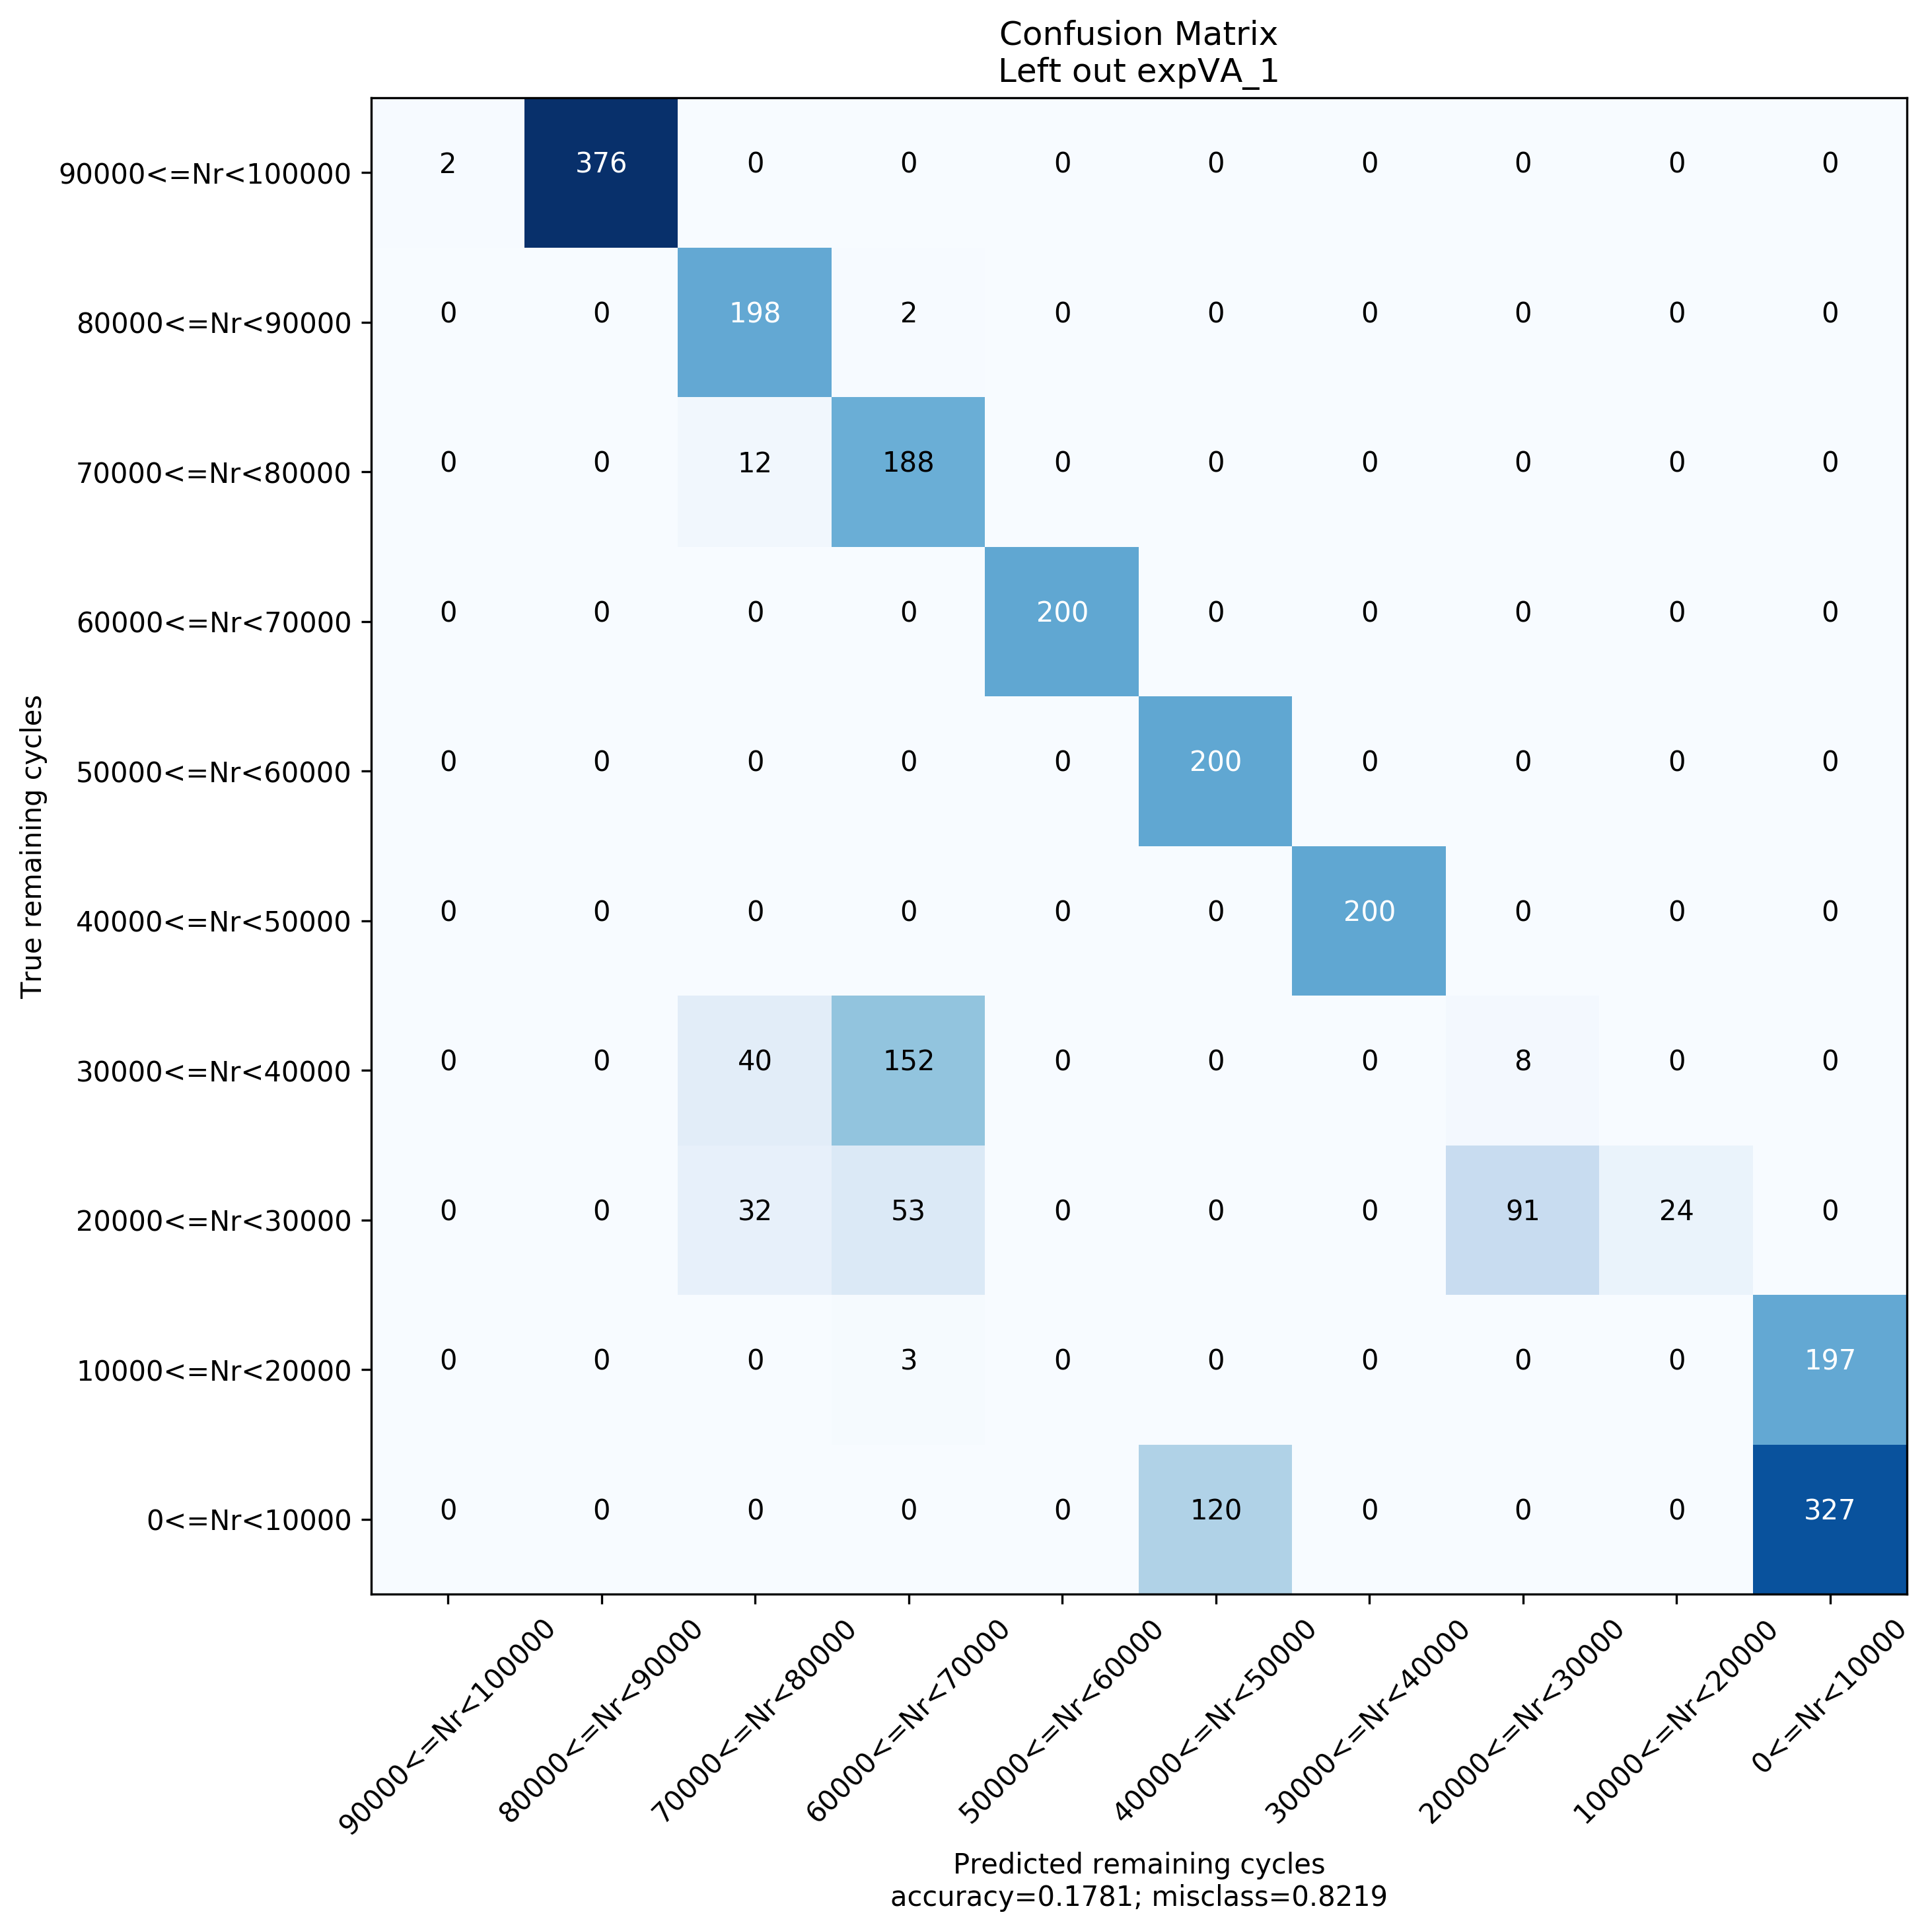

5395/5395 [==============================] - 7s 1ms/sample - loss: 0.1130 - ExpID_loss: 0.5135 - Y_output_loss: 1.0135 - Y_output_top3_acc: 0.9787 - val_loss: 0.2263 - val_ExpID_loss: 0.0000e+00 - val_Y_output_loss: 2.1452 - val_Y_output_top3_acc: 0.7221
Epoch 92/100
5395/5395 [==============================] - 4s 737us/sample - loss: 0.1159 - ExpID_loss: 0.5525 - Y_output_loss: 1.0366 - Y_output_top3_acc: 0.9761 - val_loss: 0.1943 - val_ExpID_loss: 0.0000e+00 - val_Y_output_loss: 1.8539 - val_Y_output_top3_acc: 0.8346
Epoch 93/100
5395/5395 [==============================] - 4s 736us/sample - loss: 0.1165 - ExpID_loss: 0.5590 - Y_output_loss: 1.0416 - Y_output_top3_acc: 0.9765 - val_loss: 0.1553 - val_ExpID_loss: 0.0000e+00 - val_Y_output_loss: 1.4910 - val_Y_output_top3_acc: 0.8829
Epoch 94/100
5395/5395 [==============================] - 4s 734us/sample - loss: 0.1130 - ExpID_loss: 0.5632 - Y_output_loss: 1.0069 - Y_output_top3_acc: 0.9813 - val_loss: 0.1900 - val_ExpID_loss: 0.0000

In [98]:
epochs = 100; #training_parameters["nepochs"]
batchsize =100;

from tensorflow.math import confusion_matrix
import tensorflow.keras as keras
from tensorflow.keras import layers 
lrate = 0.001


es = keras.callbacks.EarlyStopping(monitor='val_Y_output_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

class Top3AccStrong(tf.keras.callbacks.Callback):
    def __init__(self):
        self.top3acc_strong = []
    def on_epoch_end(self,epoch,logs = None):
        top3acc = plot_cmatrix_strong_return_top3acc(leave_exp_out, epoch, 0.001,root_folder = "/tmp")
        self.top3acc_strong.append(top3acc)


class InspectActivations(tf.keras.callbacks.Callback):
        
    def __init__(self):
        None
        
    def on_epoch_end(self,epoch,logs = None):
        
        print("Plotting output activation statistics from DN:")
        plot_dn_output_activation_statistics()
        pplot.show()
        pplot.pause(0.1)


def top3_acc(labels, logits):
    return keras.metrics.top_k_categorical_accuracy(labels,logits, k=3)



def plot_confusion():
    cmat = confusion_matrix(np.argmax(Yoh,1),np.argmax(Yhat,1))
    pplot.pcolor(cmat.eval())
    pplot.show()

adv_loss = {"ExpID" : tf.compat.v1.losses.softmax_cross_entropy}
loss_fcn = {"Y_output" :tf.compat.v1.losses.softmax_cross_entropy,
            "ExpID" : lambda y,yhat : tf.compat.v1.losses.softmax_cross_entropy(y,yhat)}

loss_w = {"Y_output": 0.66*3./(3.+15.)*(1-c_loss),"ExpID" : 0.33*15./(3.+15.)*c_loss }

# GOAL: Minimize the useless discriminator while maximizing the useful classifier.

# useful discriminator:
model_opt = keras.optimizers.Adam(learning_rate=lrate);
model.compile(optimizer =  model_opt,
              loss =loss_fcn,
              loss_weights = loss_w,
              metrics = {"Y_output" : top3_acc})

train_in, train_out = [{"timeseries_input": Xtrain},{"Y_output":local_smooth_labels(Ytrain),  "ExpID" : EIDTrain}]
#test_in, test_out = [{"timeseries_input" : Xtest}, {"Y_output" : Ytest, "ExpID" : EIDTest}]
# I use the left-out experiment as validation set. 
# The only info used from the left-out set is when to stop training.
# Results are good also by using a validation set from the "seen" experiments.
test_in, test_out = [{"timeseries_input" : Xstrong}, {"Y_output" : YstrongOH, "ExpID" : np.zeros([YstrongOH.shape[0],3])}]

history_d = model.fit(train_in, train_out, epochs=epochs,
                     batch_size=batchsize,
                      validation_data = [test_in, test_out],# "Rc_output" :  RemCTest}],
                     callbacks=[es, Top3AccStrong()])#, InspectActivations()]);#, Top3AccStrong()])




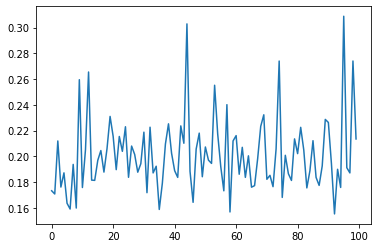

In [99]:
pplot.plot(history_d.history['val_loss'])

In [102]:

pplot.plot(np.argmax(res,1)*10000, np.max(Yp)-Ypred_strong_seq[::1][:-1],'.')
pplot.xlabel("predicted")
pplot.ylabel("true")


NameError: name 'res' is not defined

### Estimation of remaining cycles - consequtive blocks


In [105]:
## load the larger stage-2 dataset.
#del data
#data_orig = load_hilti_fatigue_data(keep_from_end=  300000,leave_exp_out="None",stage_2_from_disk=False, nclasses = 30, user_normalization = static_normalization)
#data = load_hilti_fatigue_data(keep_from_end=  300000,leave_exp_out="None",stage_2_from_disk=True, nclasses = 30)


MemoryError: Unable to allocate array with shape (5, 38228700) and data type float64

In [32]:
#[X_all_large,Y_all_large,Yoh_all_large, eid_vector_all_large] = data_orig['training_instances']
[X_all_large,Y_all_large,Yoh_all_large, eid_vector_all_large] = [X_all_0,Y_all_0,Yoh_all_0, eid_vector_all_0] 


## Inspection of the evolution of the predictions
* The following are not confusion matrices. They are softmax scores for consecutive predictions. The bottom right block are the cycles closer to failure that are sampled with a higher resolution for all experiments.
* For the held-out experiment a trend towards failure for subsequent cycles in indeed followed. 
* For almost all samples less than 10k cycles from failure the prediction is very accurate (in the final stage of fatigue). 

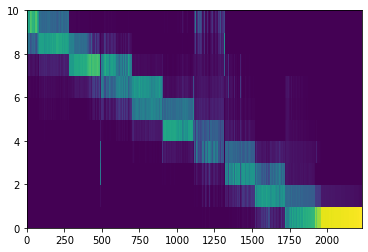

In [108]:
#pplot.plot(Y_all_large)
Xp  = X_all[eid_vector_all=='VA_3']
Yp = Y_all[eid_vector_all=='VA_3']
preds = model.predict(Xp, batch_size=100)
pplot.pcolor(tf.math.softmax(preds[1],axis = 1).eval().T)
pplot.show()


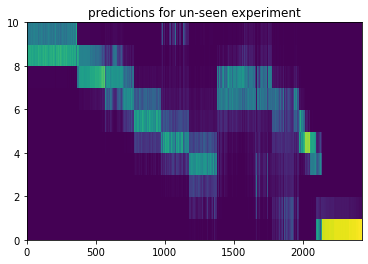

In [111]:
Xp  = X_all[eid_vector_all=='VA_1']
Yp = Y_all[eid_vector_all=='VA_1']
preds = model.predict(Xp, batch_size=100)
pplot.pcolor(tf.math.softmax(preds[1],axis = 1).eval().T)
pplot.title("predictions for un-seen experiment")
pplot.show()


In [2]:
pplot.plot(np.argmax(preds[1],1)*10000,Yp,'.')

NameError: name 'pplot' is not defined

In [4]:
!git stage *

^C


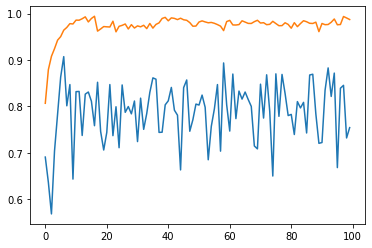

In [114]:
pplot.plot(history_d.history['val_Y_output_top3_acc'])
pplot.plot(history_d.history['Y_output_top3_acc'])

In [174]:

ii = inspect_model.predict(X_all[eid_vector_all == 'VA_3'][::10,:,:], batch_size=100)[:,::10,:]
ii2 = inspect_model.predict(X_all[eid_vector_all == 'VA_1'][::10,:,:], batch_size=100)[:,::10,:]
#ii2 = inspect_model.predict(X_all[eid_vector_all == 'VA_1'], batch_size=100)


InternalError: Could not allocate ndarray

In [175]:
ii

array([[[ 0.02455424, -0.05125172,  0.0156762 , ...,  0.32298848,
         -0.23385434,  0.03475825],
        [ 0.03307894, -0.03822584,  0.02437046, ...,  0.23283048,
         -0.22995602,  0.00403493],
        [ 0.04142685, -0.01346474,  0.03069373, ...,  0.21019481,
         -0.21038789,  0.02927521],
        ...,
        [ 0.06199255,  0.06648868,  0.02529821, ..., -0.0139956 ,
          0.04540969,  0.09634419],
        [ 0.04210283,  0.03694082,  0.01254358, ..., -0.02064074,
          0.13138147,  0.15446074],
        [ 0.03879598,  0.01710057,  0.0108309 , ..., -0.0073189 ,
         -0.02633845,  0.14240927]],

       [[ 0.00661216, -0.06701907,  0.0147555 , ...,  0.2896095 ,
         -0.17562984,  0.01041892],
        [ 0.02645993, -0.03991323,  0.03833175, ...,  0.21424846,
         -0.20453559,  0.03459481],
        [ 0.04198286,  0.00197515,  0.04320936, ...,  0.18452972,
         -0.20685337,  0.04850903],
        ...,
        [ 0.04271265,  0.04671   ,  0.0069071 , ...,  

In [166]:
from sklearn.decomposition import PCA

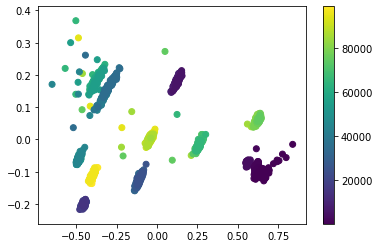

In [167]:
pca = PCA(n_components = 3)
p = pca.fit(np.mean(ii,1)).transform(np.mean(ii,1))
pplot.scatter(p[:,0], p[:,1], c = Y_all[eid_vector_all == 'VA_3'])
pplot.colorbar()


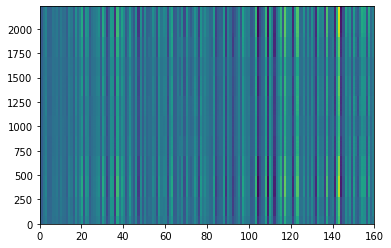

In [151]:
pplot.pcolor(np.mean(ii,1))

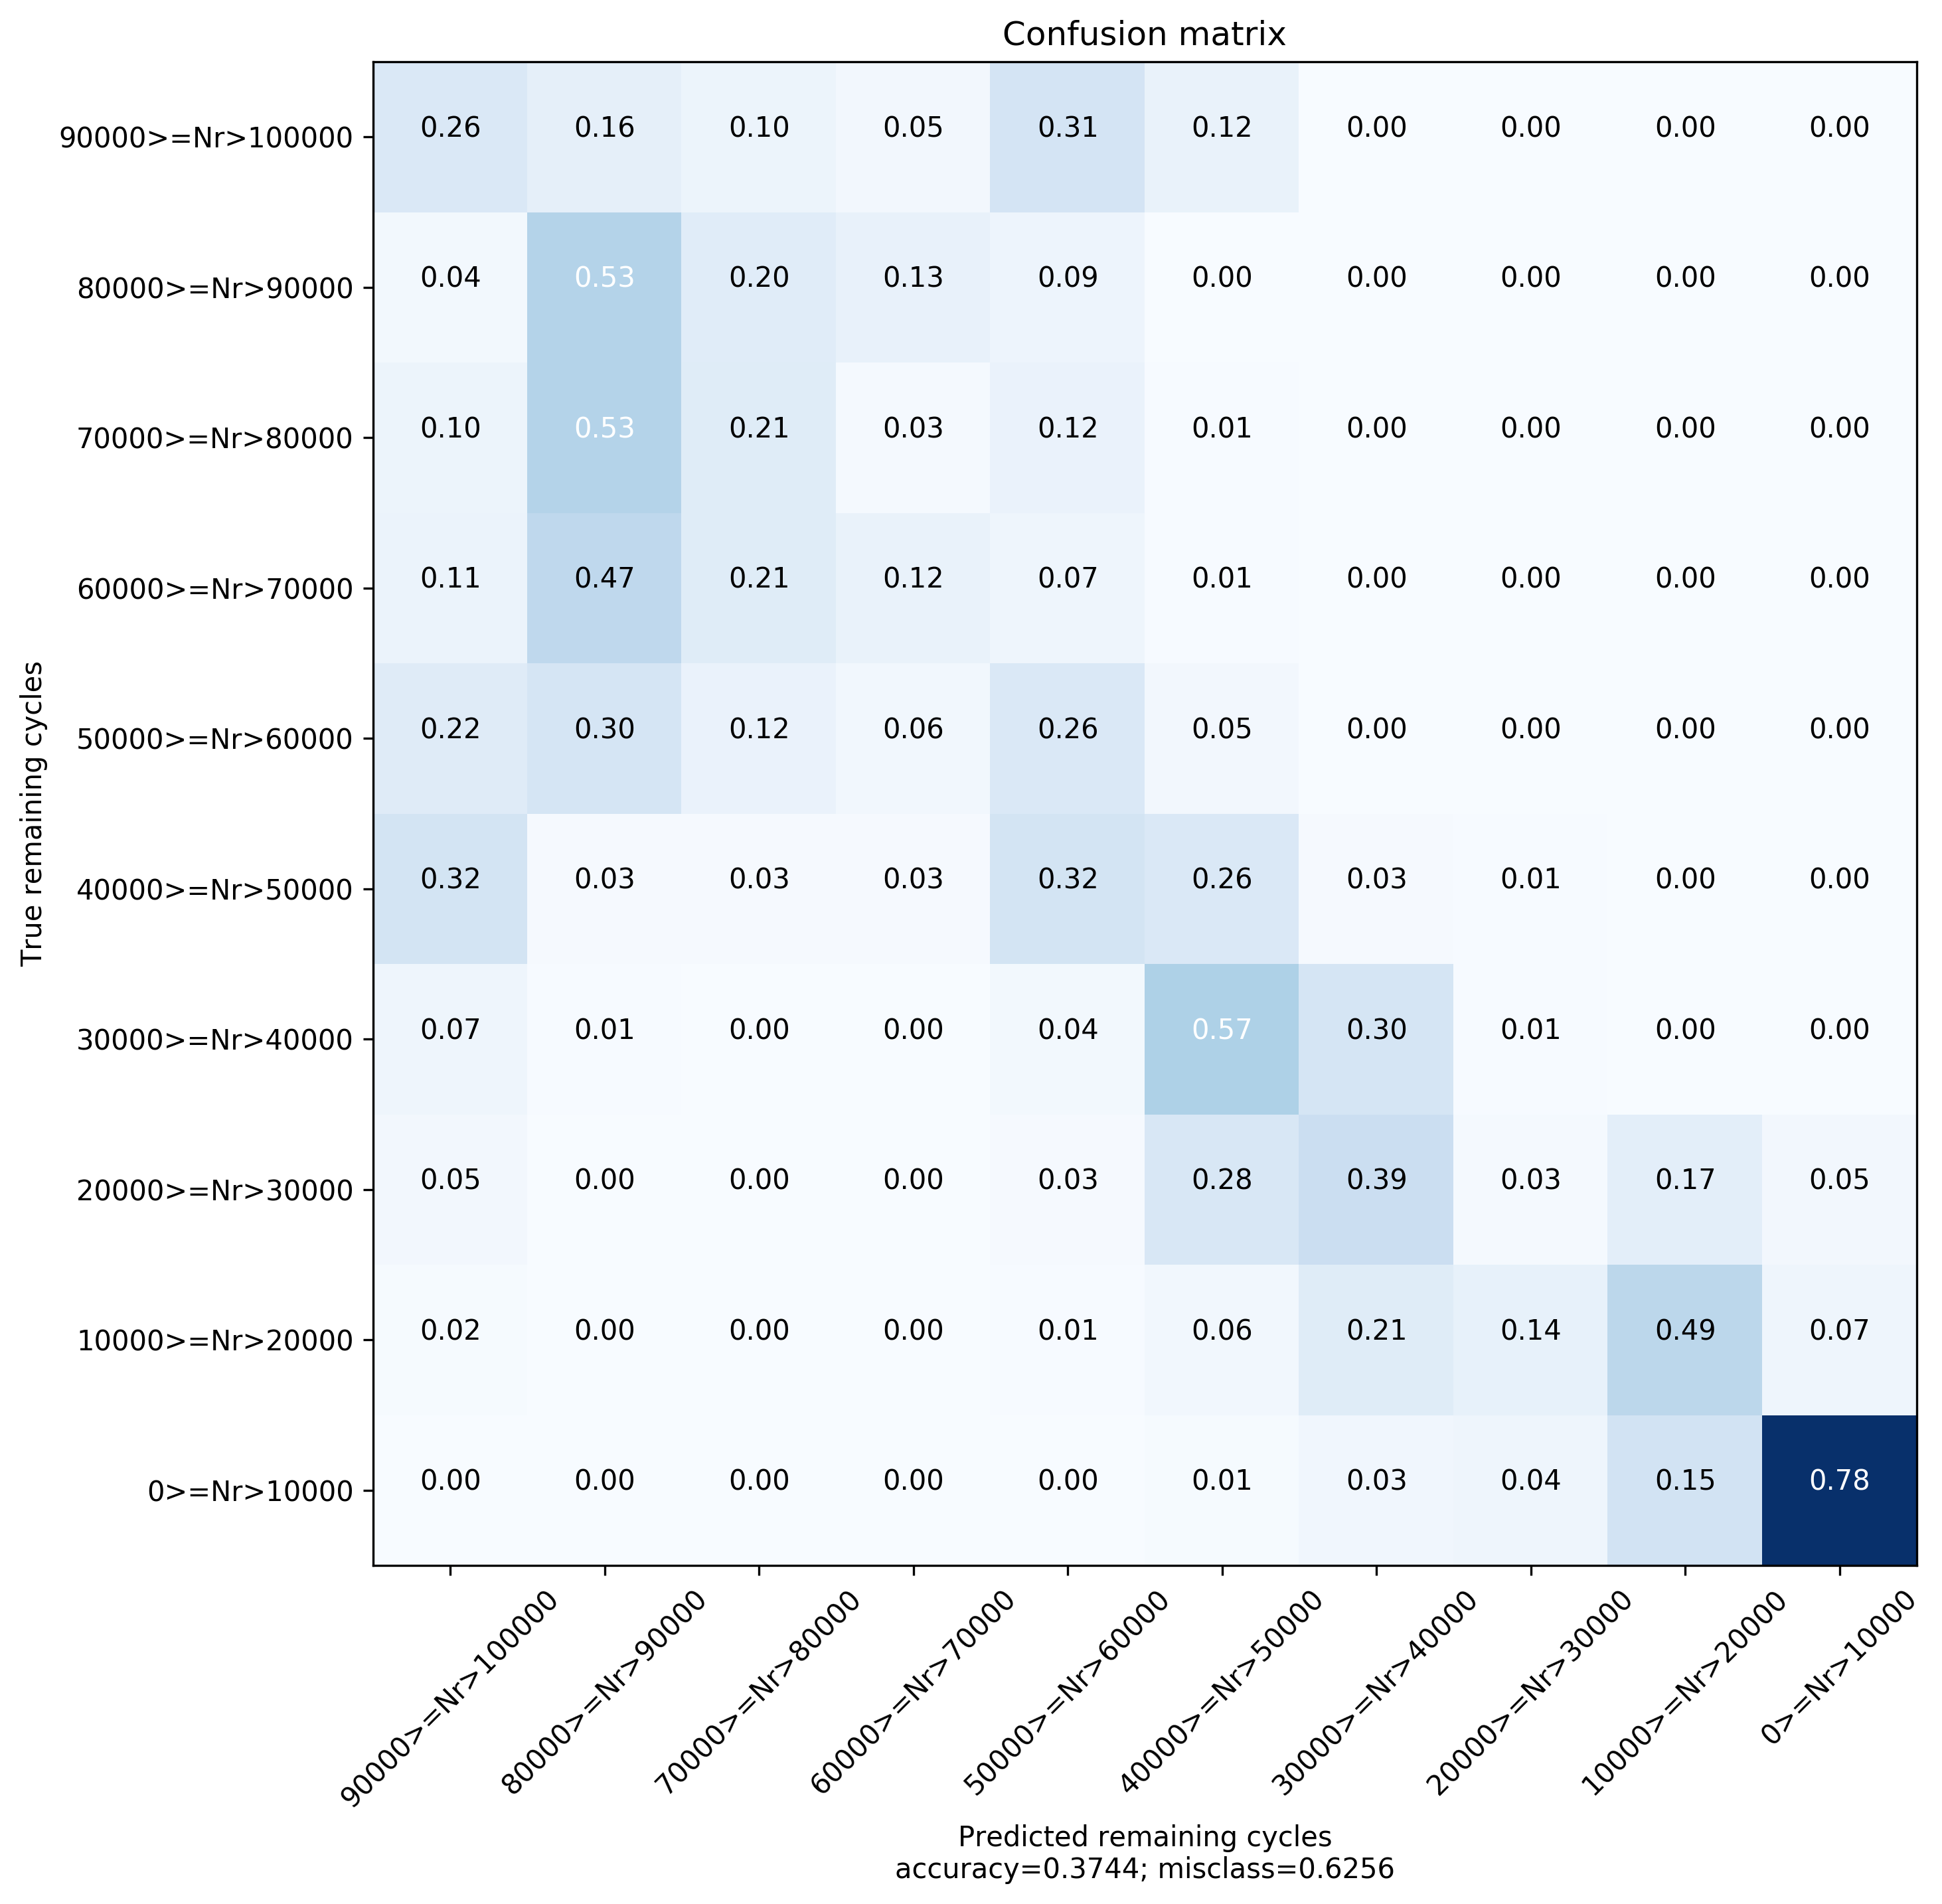

In [369]:
yhat = model.predict(Xtest, batch_size=100)[1]
crange = 10000
if tf.executing_eagerly():
    cmat = tf.confusion_matrix(tf.argmax(Ytest,1), tf.argmax(yhat,1)).numpy()
else:
    cmat = tf.confusion_matrix(tf.argmax(Ytest,1), tf.argmax(yhat,1)).eval(session = tf.keras.backend.get_session())
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(int(cmat.shape[0]))]
plot_confusion_matrix(cmat, target_names = target_names, normalize=True)

In [148]:

#model.save("trained_model_VA2/model_")
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
timeseries_input (InputLayer)   [(None, 1500, 6)]    0                                            
__________________________________________________________________________________________________
DN_DN1_C1D (Conv1D)             (None, 1500, 20)     140         timeseries_input[0][0]           
__________________________________________________________________________________________________
DN_DN1_idx_0 (Sequential)       (None, 1500, 20)     2440        DN_DN1_C1D[0][0]                 
__________________________________________________________________________________________________
DN_DN1_idx_1 (Sequential)       (None, 1500, 20)     2440        DN_DN1_idx_0[0][0]               
                                                                 DN_DN1_C1D[0][0]           

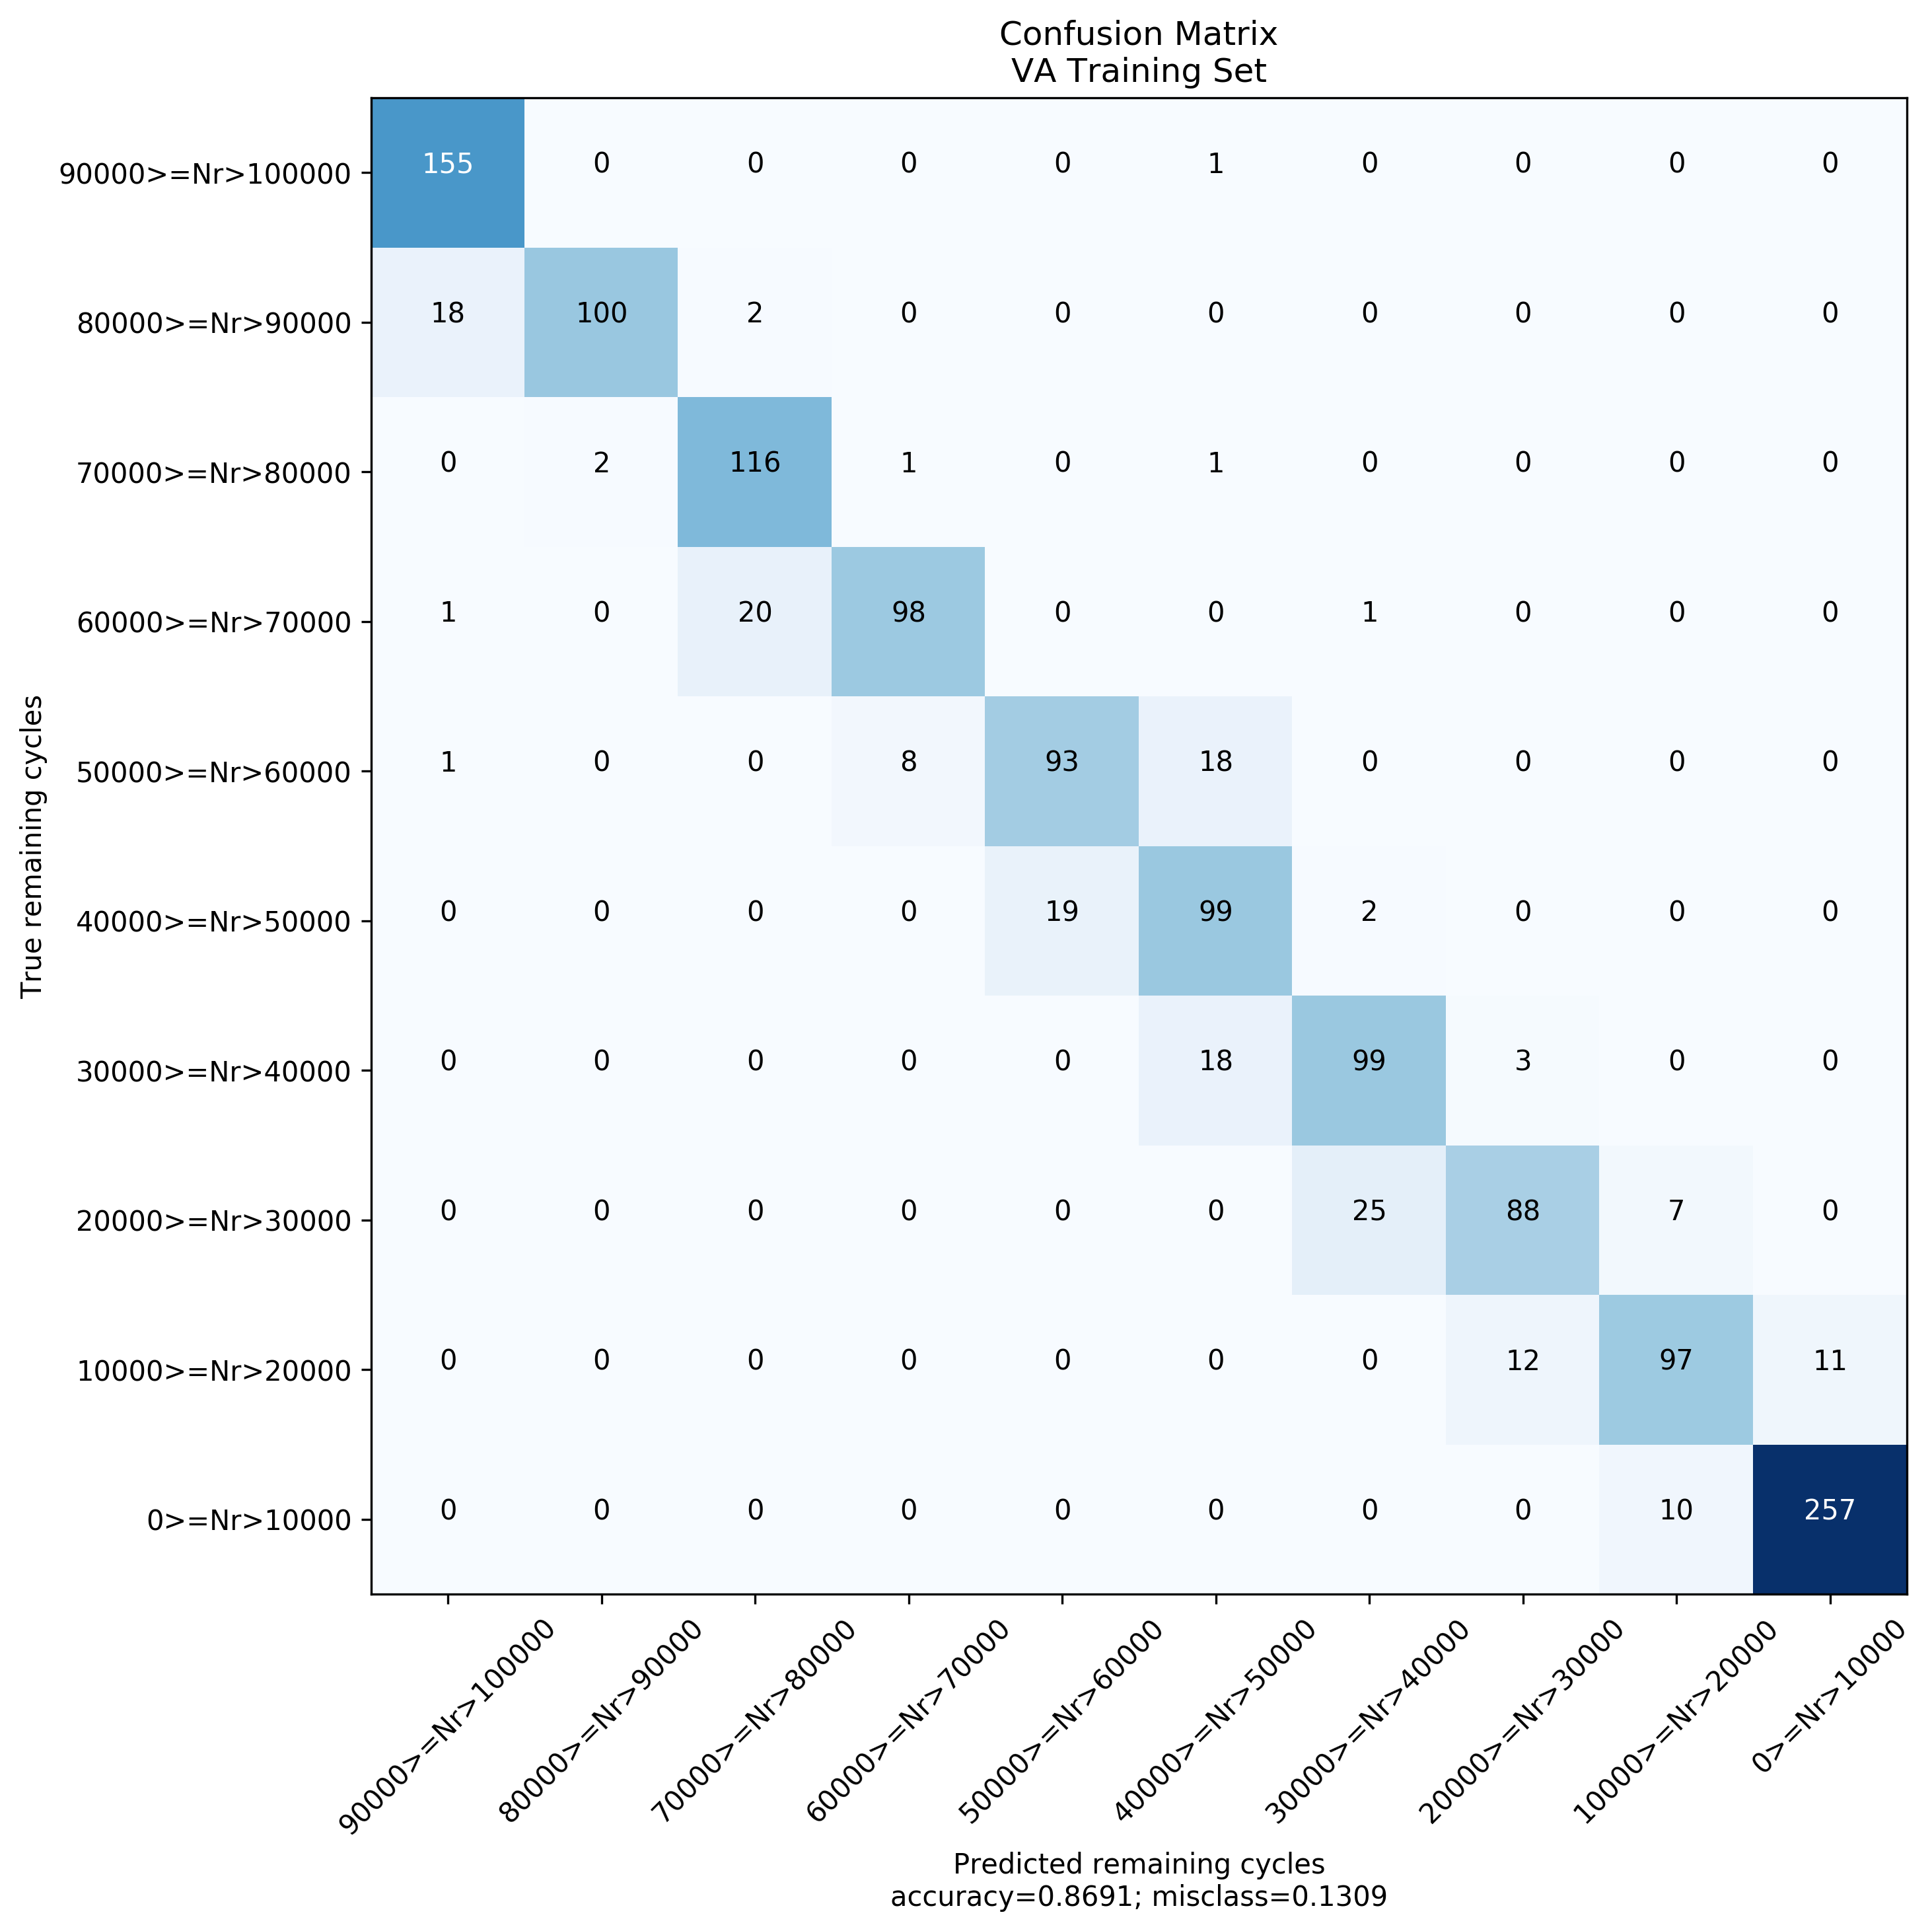

In [31]:
yyhat = model.predict(Xtest)
cmat = confusion_matrix(np.argmax(Ytest,1),np.argmax(yyhat[1],1))
#cmat = cmat[0:-1,0:-1]
crange = int(150000/15);
target_names = ["%i>=Nr>%i"%((i)*crange,(i+1)*crange) for i in range(cmat.shape[0])]
plot_confusion_matrix(cmat.eval(session = keras.backend.get_session()),
                      target_names = target_names , figsize = (10,10), normalize= False, title = "Confusion Matrix\nVA Training Set")
